## SSB S4 Courswork - Modelling a Genetic Oscillator (Repressilator)

The genetic oscillator modelled below is a version of the Elowitz and Leibler (2000) repressilator. Stable oscillations can be induced by transient exposure to IPTG, and terminated by exposure to AHL which forms a complex with constitutively expressed LuxR and activates one component of the system while repressing the another. The Caltech "Intorduction to Biological Circuit Design" online course was used as a guide for constructing the below code (https://biocircuits.github.io/chapters/01_intro_to_circuit_design.html#:~:text=Biological%20circuits%20are%20sets%20of,Feature%20X%20enables%20Function%20Y).

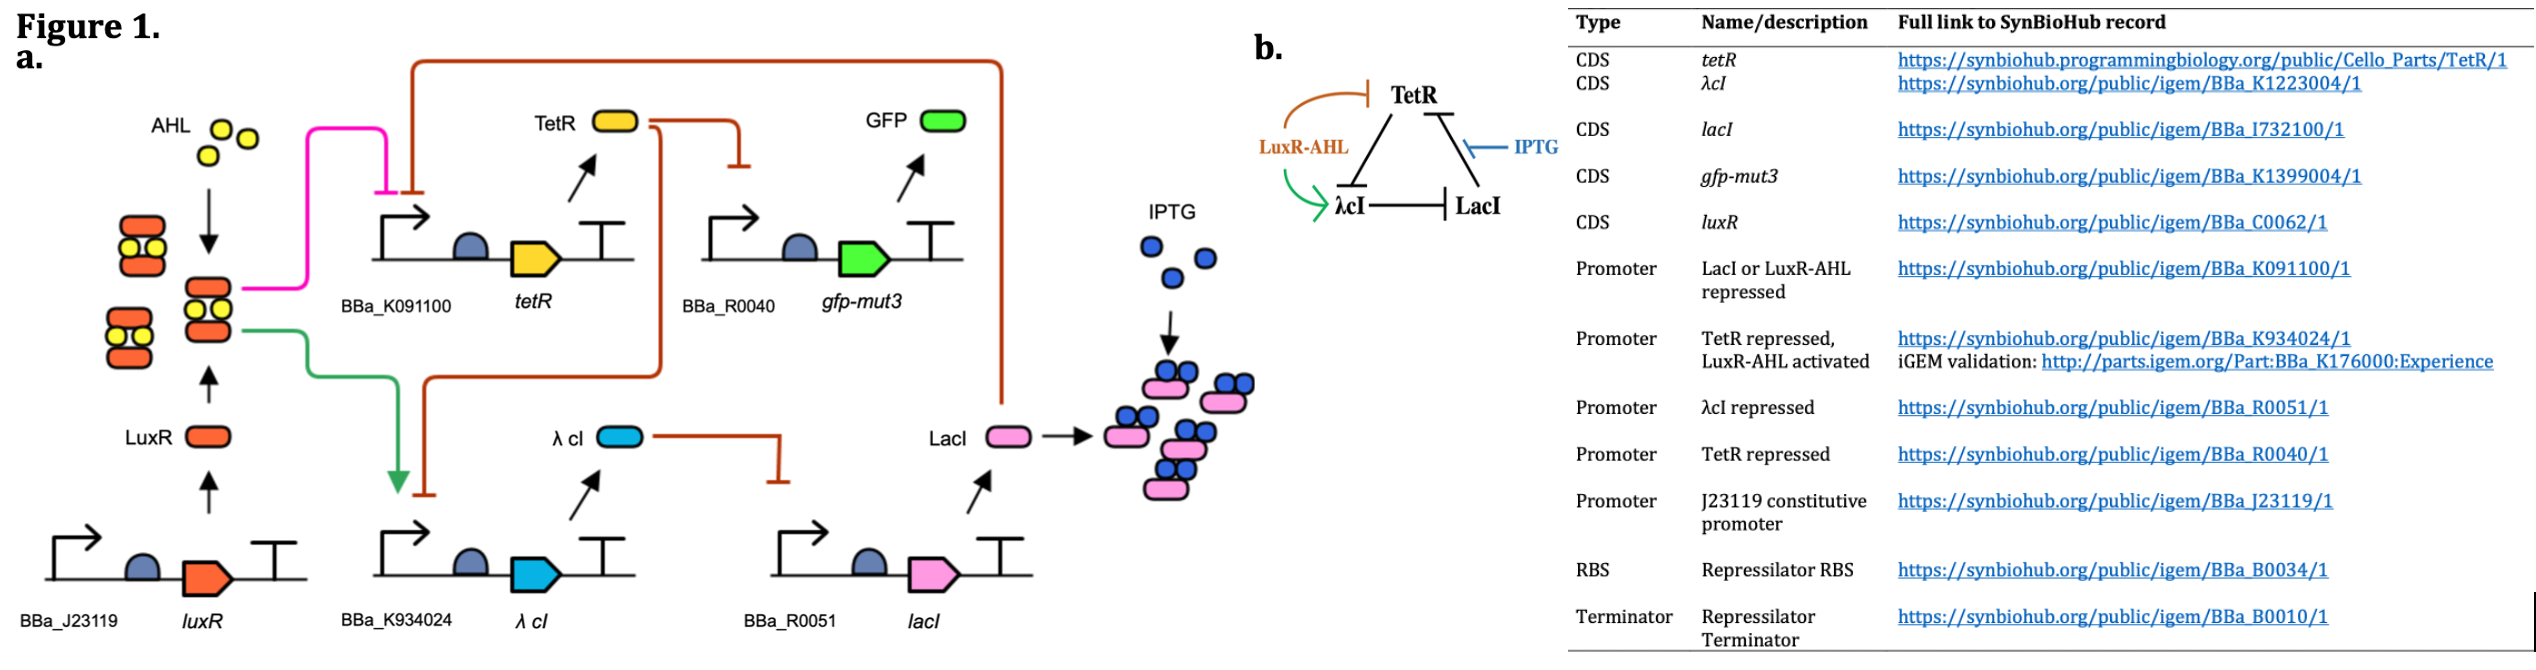

Figure 1. **a.** The components of the central ‘repressilator’ circuit are connected by the red inhibitory arrows. When TetR (yellow) is highly expressed, it represses λcI (blue), which allows LacI (pink) to be expressed. As the concentration of LacI increases it begins to repress TetR, meaning λcI is now free to be expressed. λcI will then repress LacI, which will allow levels of TetR to increase again, completing the cycle. GFP (green) is also repressed by TetR and will oscillate with λcI. If IPTG is introduced (small purple molecules), it binds to LacI and prevents it from inhibiting TetR. If AHL is introduced (small yellow molecules), it forms a complex with LuxR (orange) which is constitutively expressed. The LuxR-AHL complex disrupts the oscillations by inhibiting TetR, and inducing λcI, which will in turn repress LacI. Promoters are labelled with their BioBrick ID as listed in Table 1. For all constructs the RBS and terminator sequences used are the ones listed in Table 1 (unlabeled above to allow readability of promoter and coding sequences). **b.** Basic circuit design: The three- gene negative feedback loop (black), regulated by IPTG (blue) and LuxR-AHL (orange/green).

In [1]:
import numpy as np
import scipy.integrate
import scipy.optimize

import bokeh.plotting
import bokeh.io
import colorcet

# Using Matplotlib to make 3D limit cycle plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import panel as pn
pn.extension()

bokeh.io.output_notebook()

Loading BokehJS ...

**Repressilator function**

(Time periods for IPTG and LuxR-AHL exposure can be specified within the function)

In [2]:
def repressilator(p, t, T_beta, T_n, C_beta, C_n, Lc_beta, Lc_n):  
    """
    Returns 3-array of (dTetR/dt, dlambdaCI/dt, dLacI/dt)
    
    T  = TetR
    C  = lambda CI 
    Lc = LacI
    
    LxA = LuxR-AHL complex
    
    """
    
    T, C, Lc = p 
    
    # IPTG exposure at time period 10<t<20
    if t>=10 and t<=20:
        # Updating LacI conc. to conc. of LacI unbound by IPTG (IPTG conc. = 2, Kd = 1.4, n = 2 - doi:10.1021/bi9002343)
        Lc = Lc/(1 + (2/1.4)**2)                               
    else:
        Lc = Lc
    

    # Addition of AHL from timepoint 130 (LuxR-AHL conc. set as 2*TetR conc.)
    if t>=125:
        LxA = T*2
    else:
        LxA = 0.0
                        
    
    # Change in repressor concentrations
    dT_dt = T_beta/(1 + (Lc**Lc_n) + (LxA**1)) - T
    dC_dt = (C_beta + C_beta*(LxA**3))/((1 + LxA**3) + T**T_n) - C   
    dLc_dt = Lc_beta / (1 + C**C_n) - Lc
    
    
    return np.array([dT_dt, dC_dt, dLc_dt])
        
        
   


In [3]:
# Initial conditions

# Simulation time length
t_max0 = 150

# Starting protein concentrations [TetR, lambdaCI, LacI]
p0 = np.array([1, 1, 1])

# Parameter settings (initial values - can change in interactive plot)
param_T  = {'beta': 10, 'n': 3}
param_C  = {'beta': 10, 'n': 3}
param_Lc = {'beta': 10, 'n': 3}


In [4]:
## Widgets for interactive plot

t_max_slider = pn.widgets.FloatSlider(name="t_max", start=1, end=100, step=1, value=t_max0)

# TetR
T_beta_slider = pn.widgets.FloatSlider(name="TetR β", start=1, end=100, step=0.1, value=param_T['beta'])
T_n_slider    = pn.widgets.FloatSlider(name="TetR n", start=1, end=5, step=0.1, value=param_T['n'])

# Lambda CI
C_beta_slider = pn.widgets.FloatSlider(name="lambda CI β", start=1, end=100, step=0.1, value=param_C['beta'])
C_n_slider    = pn.widgets.FloatSlider(name="lambda CI n", start=1, end=5, step=0.1, value=param_C['n'])

# LacI
Lc_beta_slider = pn.widgets.FloatSlider(name="LacI β", start=1, end=100, step=0.1, value=param_Lc['beta'])
Lc_n_slider    = pn.widgets.FloatSlider(name="LacI n", start=1, end=5, step=0.1, value=param_Lc['n'])


In [5]:
# Build the reactive plot

legend = ['TetR', 'lambda CI', 'LacI']

# repressilator_plot function will use the below slider values as inputs
@pn.depends(
    t_max = t_max_slider.param.value,
    T_beta   = T_beta_slider.param.value, 
    T_n      = T_n_slider.param.value,
    C_beta   = C_beta_slider.param.value, 
    C_n      = C_n_slider.param.value,
    Lc_beta  = Lc_beta_slider.param.value, 
    Lc_n     = Lc_n_slider.param.value
    )

# Solve repressilator function to generate values for plot
def repressilator_plot(t_max, T_beta, T_n, C_beta, C_n, Lc_beta, Lc_n):
    
    n_points = 1000
    
    # Solve for species concentrations
    t = np.linspace(0, t_max, n_points)
    p = scipy.integrate.odeint(
        repressilator, p0, t, args=(T_beta, T_n, C_beta, C_n, Lc_beta, Lc_n))
    
    # Plot specifications
    colors = colorcet.b_glasbey_bw_minc_20[24:27]

    plot = bokeh.plotting.figure(
        frame_width=900, frame_height=200, x_axis_label="time", x_range=[0,t_max+1], y_axis_label = "concentration")

    for i, p_vals in enumerate(p.transpose()):
        plot.line(
            t, p_vals, line_width=2, color=colors[i], legend_label=legend[i])

    plot.legend.location = "top_left"

    return plot


# Call plotting function specifying panel layout
pn.Column(
    pn.Row(t_max_slider, width=150),
    pn.Spacer(height=10),
    pn.Row(T_beta_slider, T_n_slider, C_beta_slider, C_n_slider, Lc_beta_slider, Lc_n_slider, width=900),
    pn.Spacer(height=10),
    repressilator_plot)

Column
    [0] Row(width=150)
        [0] FloatSlider(end=100, name='t_max', start=1, step=1, value=150)
    [1] Spacer(height=10)
    [2] Row(width=900)
        [0] FloatSlider(end=100, name='TetR β', start=1, value=10)
        [1] FloatSlider(end=5, name='TetR n', start=1, value=3)
        [2] FloatSlider(end=100, name='lambda CI β', start=1, value=10)
        [3] FloatSlider(end=5, name='lambda CI n', start=1, value=3)
        [4] FloatSlider(end=100, name='LacI β', start=1, value=10)
        [5] FloatSlider(end=5, name='LacI n', start=1, value=3)
    [3] Spacer(height=10)
    [4] ParamFunction(function)

**Phase trajectory in 3D (limit cycle)** 

3D plot of the limit cycle in the space of the three protein concentrations

In [6]:
# (Repressilator function without modelling IPTG/LuxR-AHL inputs)
def repressilator_lim(p, t, T_beta, T_n, C_beta, C_n, Lc_beta, Lc_n):  
    """
    Returns 3-array of (dTetR/dt, dlambdaCI/dt, dLacI/dt)
    
    T  = TetR
    C  = lambda CI 
    Lc = LacI
    
    LxA = LuxR-AHL complex
    
    """
    
    T, C, Lc = p 
    
    LxA = 0.0
                        
    # Change in repressor concentrations
    dT_dt = T_beta/(1 + (Lc**Lc_n) + (LxA**1)) - T
    dC_dt = (C_beta + C_beta*(LxA**3))/((1 + LxA**3) + T**T_n) - C   
    dLc_dt = Lc_beta / (1 + C**C_n) - Lc
    
    
    return np.array([dT_dt, dC_dt, dLc_dt])

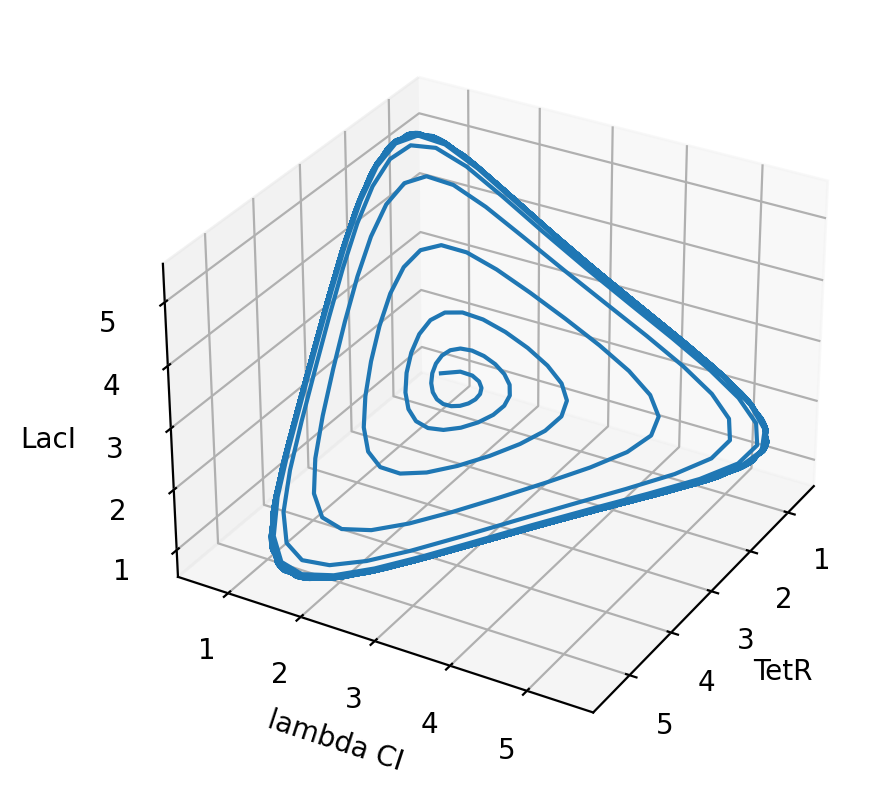

In [7]:
# Plotting limit cycle using initial settings for the repressors as defined in the param_ dictionaries

# Initial concentrations - need initial imbalance as not modelling IPTG
p0_lim = [1,1,1.2]

t = np.linspace(0, t_max0, 1000)
x = scipy.integrate.odeint(repressilator_lim, p0_lim, t, 
                           args=(param_T['beta'], param_T['n'], 
                                 param_C['beta'], param_C['n'], 
                                 param_Lc['beta'], param_Lc['n'])
                          )

# Generate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("TetR")
ax.set_ylabel("lambda CI")
ax.set_zlabel("LacI");

**2D interactive phase plot**

In [8]:
@pn.depends(
    t_max    = t_max_slider.param.value,
    T_beta   = T_beta_slider.param.value, 
    T_n      = T_n_slider.param.value,
    C_beta   = C_beta_slider.param.value, 
    C_n      = C_n_slider.param.value,
    Lc_beta  = Lc_beta_slider.param.value, 
    Lc_n     = Lc_n_slider.param.value
    )
    
def phase_plot(t_max, T_beta, T_n, C_beta, C_n, Lc_beta, Lc_n):
    # Solve for species concentrations
    t = np.linspace(0, t_max, 1000)
    x = scipy.integrate.odeint(repressilator_lim, p0_lim, t,
                              args=(T_beta, T_n, C_beta, C_n, Lc_beta, Lc_n))
    x1, x2, x3 = x.transpose()

    p = bokeh.plotting.figure(
        frame_width=300,
        frame_height=300,
        x_axis_label="x₁",
        y_axis_label="x₂",
    )

    p.line(x1, x2, line_width=2)

    return p


pn.Column(
    pn.Row(t_max_slider, width=150),
    pn.Spacer(height=10),
    pn.Row(T_beta_slider, T_n_slider, C_beta_slider, C_n_slider, Lc_beta_slider, Lc_n_slider, width=900),
    pn.Spacer(height=10),
    phase_plot
)

Column
    [0] Row(width=150)
        [0] FloatSlider(end=100, name='t_max', start=1, step=1, value=150)
    [1] Spacer(height=10)
    [2] Row(width=900)
        [0] FloatSlider(end=100, name='TetR β', start=1, value=10)
        [1] FloatSlider(end=5, name='TetR n', start=1, value=3)
        [2] FloatSlider(end=100, name='lambda CI β', start=1, value=10)
        [3] FloatSlider(end=5, name='lambda CI n', start=1, value=3)
        [4] FloatSlider(end=100, name='LacI β', start=1, value=10)
        [5] FloatSlider(end=5, name='LacI n', start=1, value=3)
    [3] Spacer(height=10)
    [4] ParamFunction(function)